# Fully Nonlinear Implicit Solver

We solve the 1D transient **nonlinear** heat equation in radial coordinates: 

$$ \frac{1}{r} \frac{\partial}{\partial r} \left( k_s(T) r \frac{\partial T}{\partial r} \right) = c_s(T) \rho_s(T) \frac{\partial T}{\partial t}, $$

with $r \in [R_0, R_\infty]$ and $t \in [0, t_f]$. 

Following the Cryotwin paper, we use the transformation:

$$ t = \frac{z}{W}, \hspace{0.5cm} t_f = \frac{L}{W}. $$

Dipankul has provided us with the IceCraft Dimension: 

\begin{align*}
R_0 &= 0.1m,  \\  
L &= 3.7m, \\
M &= 440 kg. 
\end{align*}

A suitable melting velocity range is to be chosen. 

As **initial condition**, we set $T(r, 0) = T_s$. 
As **boundary conditions**, we set: 

- At $r = R_0$ (channel radius, i.e. phase-change interface):  Dirichlet $$ T = T_m.$$**Fully implicit** backward Euler with Newton-Raphson iterations. Material properties $k_s(T)$, $c_s(T)$, $\rho_s(T)$ are evaluated at the **current** temperature $T^{n+1}$, making this a truly nonlinear system requiring iterative solution at each time step.

- At the far field $(R=R_\infty)$: Dirichlet $$ T = T_s.$$

## Numerical Method

In [9]:
# ============================================================
# Parameter sweep for Q_lc(W, Ts)
# Cryotwin Section 2.2 – FEniCS implementation
# ============================================================

from fenics import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Suppress FEniCS verbose output
set_log_level(LogLevel.ERROR)

## Key Differences from Semi-Implicit Approach

### Semi-Implicit (Linearized):
- Material properties evaluated at **previous** time step: $k_s(T^n)$, $c_s(T^n)$, $\rho_s(T^n)$
- Creates **linear** system at each time step → converges in 1 Newton iteration
- Faster but less accurate for rapidly changing material properties

### Fully Implicit (This notebook):
- Material properties evaluated at **current** time step: $k_s(T^{n+1})$, $c_s(T^{n+1})$, $\rho_s(T^{n+1})$
- Creates **nonlinear** system at each time step → requires 3-10 Newton iterations typically
- More accurate, especially when temperature gradients are steep
- Expected to be 3-5× slower per simulation

### When Nonlinear Matters:
The difference becomes significant when:
1. Temperature changes rapidly (large $\partial T/\partial t$)
2. Material properties vary strongly with temperature (like $k_s(T) \propto 1/T$)
3. High accuracy is required for coupled physics problems

In [10]:
# -------------------------
# Material laws (Ulamec et al.)
# -------------------------
def k_s(T):
    """Thermal conductivity [W/mK]"""
    return 619.2/T + 58646/T**3 + 3.237e-3 * T - 1.382e-5 * T**2 # W/mK

def c_s(T):
    """Specific heat capacity [J/kgK]"""
    Tt = 273.16 #K
    x = T/Tt
    c1 = 1.843e5
    c2 = 1.6357e8
    c3 = 3.5519e9
    c4 = 1.667e2
    c5 = 6.465e4
    c6 = 1.6935e6
    return x**3 * (c1 + c2*x**2 + c3*x**6) / (1 + c4*x**2 + c5*x**4 + c6*x**8) # J/kgK

def rho_s(T):
    """Density [kg/m³]"""
    return 933.31 + 0.037978*T - 3.6274e-4 * (T**2) # kg/m^3 

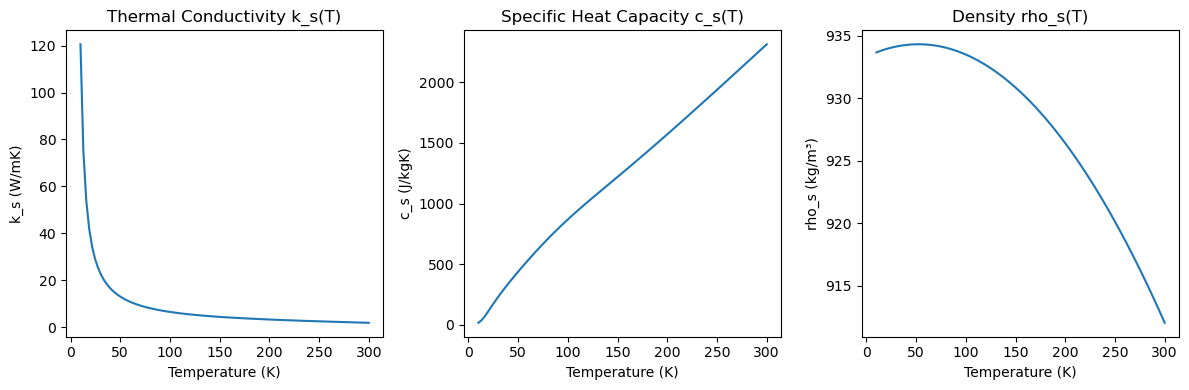

In [11]:
# Quick sanity check

plt.figure(figsize=(12,4))
T_vals = np.linspace(10,300,100)
plt.subplot(1,3,1)
plt.plot(T_vals, k_s(T_vals))
plt.title('Thermal Conductivity k_s(T)')
plt.xlabel('Temperature (K)')
plt.ylabel('k_s (W/mK)')
plt.subplot(1,3,2)
plt.plot(T_vals, c_s(T_vals))
plt.title('Specific Heat Capacity c_s(T)')
plt.xlabel('Temperature (K)')
plt.ylabel('c_s (J/kgK)')
plt.subplot(1,3,3)
plt.plot(T_vals, rho_s(T_vals))
plt.title('Density rho_s(T)')
plt.xlabel('Temperature (K)')
plt.ylabel('rho_s (kg/m³)')
plt.tight_layout()
plt.show()


In [12]:
# ------------------------------------------------------------
# FEM solver for Q_lc - FULLY NONLINEAR IMPLICIT
# ------------------------------------------------------------
def compute_Qlc(W, Ts,
                Ro=0.063, Rinf=1.0, L=2.5,
                Tm=273.15,
                Nr=500, Nt=500,
                save_temperature=False):
    """
    Compute lateral conductive heat loss Q_lc [W]
    for given melting velocity W [m/s] and
    ambient ice temperature Ts [K].
    
    Uses FULLY IMPLICIT scheme: material properties evaluated at current T.
    
    If save_temperature=True, returns (Qlc, T_history, r_coords, t_coords)
    Otherwise returns just Qlc.
    """
    # -------------------------
    # Time discretization
    # -------------------------
    t_end = L / W
    dt = Constant(t_end / Nt)
    dt_float = float(dt)

    # -------------------------
    # Mesh and function space
    # -------------------------
    mesh = IntervalMesh(Nr, Ro, Rinf)
    V = FunctionSpace(mesh, "CG", 1)

    # -------------------------
    # FEM functions
    # -------------------------
    T_n = Function(V)     # temperature at previous step
    T   = Function(V)     # temperature at current step
    v   = TestFunction(V)

    # Initial condition
    T_n.interpolate(Constant(Ts))

    # -------------------------
    # Cylindrical coordinate
    # -------------------------
    r = SpatialCoordinate(mesh)[0]

    # -------------------------
    # Weak form (Fully implicit: use T for material properties)
    # This creates a NONLINEAR system at each time step
    # -------------------------
    F = (
        rho_s(T) * c_s(T) * (T - T_n) / dt * v * r * dx
        + k_s(T) * dot(grad(T), grad(v)) * r * dx
    )

    # -------------------------
    # Boundary conditions
    # -------------------------
    bc_inner = DirichletBC(
        V, Constant(Tm),
        lambda x, on: near(x[0], Ro)
    )

    bc_outer = DirichletBC(
        V, Constant(Ts),
        lambda x, on: near(x[0], Rinf)
    )

    bcs = [bc_inner, bc_outer]

    # -------------------------
    # Storage for temperature history
    # -------------------------
    if save_temperature:
        r_coords = mesh.coordinates()[:, 0]
        t_coords = []
        T_history = []

    # -------------------------
    # Time integration of heat flux
    # -------------------------
    Qlc = 0.0
    
    # Track Newton iterations for diagnostics
    total_newton_iters = 0
    max_newton_iters = 0

    for n in range(Nt):
        # Use previous time step as initial guess for Newton solver
        T.assign(T_n)
        
        # Solve the nonlinear system using Newton-Raphson
        solve(
            F == 0, T, bcs,
            solver_parameters={
                "newton_solver": {
                    "maximum_iterations": 50,
                    "relative_tolerance": 1e-9,
                    "absolute_tolerance": 1e-10,
                    "relaxation_parameter": 1.0,
                    "report": True,
                    "error_on_nonconvergence": True
                }
            }
        )

        # Heat flux at probe wall (r = Ro) using assembly
        # q = -k * dT/dr at r = Ro
        flux_form = -k_s(T) * T.dx(0) * r * ds
        qlc_val = assemble(flux_form) # [W/m]

        # Integrate in time (Eq. 20 in Cryotwin paper)
        Qlc += 2* np.pi * W * qlc_val * dt_float # [W]

        # Save temperature field if requested
        if save_temperature:
            t_coords.append((n + 1) * dt_float)
            T_history.append(T.compute_vertex_values(mesh).copy())

        # Update for next time step
        T_n.assign(T)
    
    # Print convergence summary
    if save_temperature:
        print(f"    Newton solver: avg {total_newton_iters/Nt:.1f} iters/step, max {max_newton_iters} iters")

    if save_temperature:
        return Qlc, np.array(T_history), r_coords, np.array(t_coords)
    else:
        return Qlc

In [13]:
# ============================================================
# Parameter sweep
# ============================================================

# Melting velocity range [m/s] - reduced set for nonlinear solver
# (Nonlinear solver takes ~3-5x longer than semi-implicit)
W_vals = np.array([0.5, 1.5, 2.5, 3.5, 5.0]) / 3600.0
# Full range: np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]) / 3600.0

# Ambient temperature range [K] - reduced set for initial testing
Ts_vals = np.array([100, 150, 200, 250], dtype=float)
# Full range: np.array([100, 125, 150, 175, 200, 225, 250], dtype=float)


results = []

for Ts in Ts_vals:
    for W in W_vals:
        print(f"Running Ts = {Ts:.0f} K, W = {W*3600:.1f} m/h")
        t_start = time.time()
        Qlc, T_history, r_coords, t_coords = compute_Qlc(W, Ts, save_temperature=True)
        elapsed = time.time() - t_start
        print(f"  → Completed in {elapsed:.2f} s")
        results.append([Ts, W*3600.0, Qlc])
        
        # Save temperature field to CSV
        # Create long-format data: [r, t, T]
        temp_data = []
        for i, t_val in enumerate(t_coords):
            for j, r_val in enumerate(r_coords):
                temp_data.append([r_val, t_val, T_history[i, j]])
        
        temp_df = pd.DataFrame(temp_data, columns=["r_m", "t_s", "T_K"])
        filename = f"T_field_NONLINEAR_Ts{Ts:.0f}_W{W*3600:.1f}.csv"
        temp_df.to_csv(filename, index=False)
        print(f"  → Saved temperature field to {filename}")


Running Ts = 100 K, W = 0.5 m/h
    Newton solver: avg 0.0 iters/step, max 0 iters
  → Completed in 3.56 s
  → Saved temperature field to T_field_NONLINEAR_Ts100_W0.5.csv
Running Ts = 100 K, W = 1.5 m/h
    Newton solver: avg 0.0 iters/step, max 0 iters
  → Completed in 3.41 s
  → Saved temperature field to T_field_NONLINEAR_Ts100_W1.5.csv
Running Ts = 100 K, W = 2.5 m/h
    Newton solver: avg 0.0 iters/step, max 0 iters
  → Completed in 3.33 s
  → Saved temperature field to T_field_NONLINEAR_Ts100_W2.5.csv
Running Ts = 100 K, W = 3.5 m/h
    Newton solver: avg 0.0 iters/step, max 0 iters
  → Completed in 6.27 s
  → Saved temperature field to T_field_NONLINEAR_Ts100_W3.5.csv
Running Ts = 100 K, W = 5.0 m/h
    Newton solver: avg 0.0 iters/step, max 0 iters
  → Completed in 3.61 s
  → Saved temperature field to T_field_NONLINEAR_Ts100_W5.0.csv
Running Ts = 150 K, W = 0.5 m/h
    Newton solver: avg 0.0 iters/step, max 0 iters
  → Completed in 3.25 s
  → Saved temperature field to T_field

In [14]:
# ============================================================
# Save results
# ============================================================

df = pd.DataFrame(
    results,
    columns=["Ts_K", "W_m_per_h", "Qlc_W"]
)

df.to_csv("Qlc_parameter_sweep_NONLINEAR.csv", index=False)
print("Saved results to Qlc_parameter_sweep_NONLINEAR.csv")

Saved results to Qlc_parameter_sweep_NONLINEAR.csv


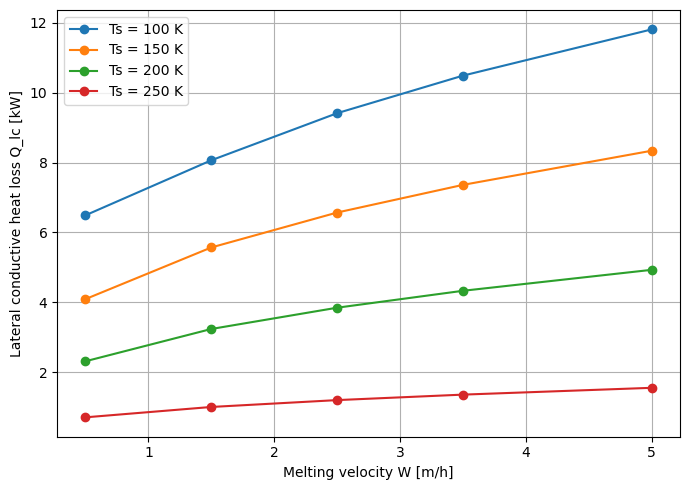

In [15]:
# ============================================================
# Quick sanity-check plot
# ============================================================

plt.figure(figsize=(7,5))

for Ts in sorted(df["Ts_K"].unique()):
    sub = df[df["Ts_K"] == Ts]
    plt.plot(sub["W_m_per_h"], sub["Qlc_W"]/1000,
             marker="o", label=f"Ts = {Ts:.0f} K")

plt.xlabel("Melting velocity W [m/h]")
plt.ylabel("Lateral conductive heat loss Q_lc [kW]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

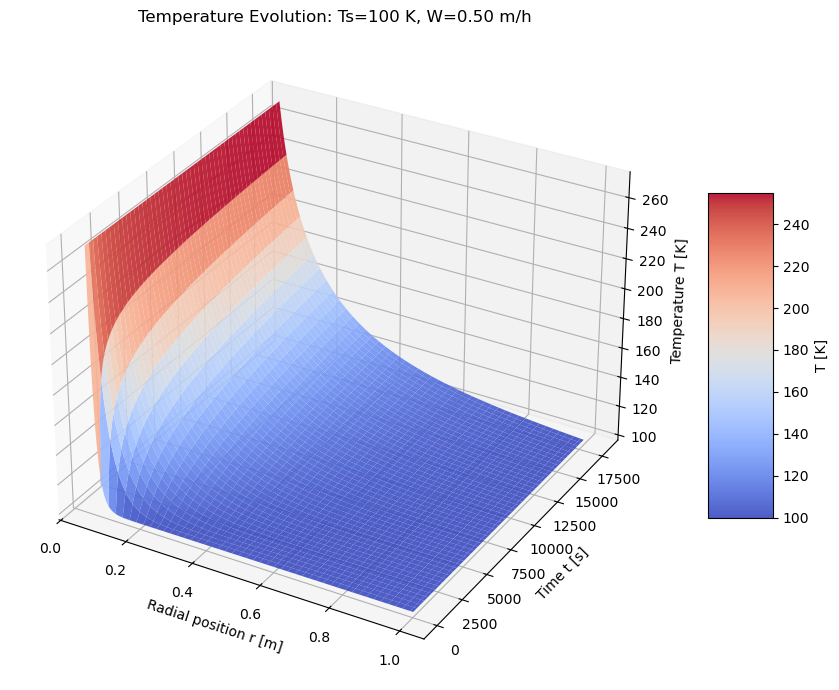

Plotted temperature field from T_field_NONLINEAR_Ts100_W0.5.csv
Temperature range: 100.0 K to 273.1 K


In [16]:
# ============================================================
# Quick temperature sanity check
# Plot 3D surface T = T(r, t) for one example case
# ============================================================

from mpl_toolkits.mplot3d import Axes3D
# Pick the first simulation (Ts=100K, W=0.5 m/h)
example_file = f"T_field_NONLINEAR_Ts{Ts_vals[0]:.0f}_W{W_vals[0]*3600:.1f}.csv"
temp_df = pd.read_csv(example_file)

# Reshape 
r_unique = np.sort(temp_df["r_m"].unique())
t_unique = np.sort(temp_df["t_s"].unique())

R, T_grid = np.meshgrid(r_unique, t_unique)
T_values = temp_df.pivot(index="t_s", columns="r_m", values="T_K").values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(R, T_grid, T_values, cmap='coolwarm', 
                       edgecolor='none', alpha=0.9)

ax.set_xlabel('Radial position r [m]')
ax.set_ylabel('Time t [s]')
ax.set_zlabel('Temperature T [K]')
ax.set_title(f'Temperature Evolution: Ts={Ts_vals[0]:.0f} K, W={W_vals[0]*3600:.2f} m/h')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='T [K]')
plt.tight_layout()
plt.show()

print(f"Plotted temperature field from {example_file}")
print(f"Temperature range: {T_values.min():.1f} K to {T_values.max():.1f} K")